In [1]:
import os
import re
import random
import glob
import argparse
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colors import Normalize, LinearSegmentedColormap
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

### Helper Functions ###

In [2]:
def check_for_nan(matrix):
    """Check if the matrix contains any NaN values."""
    return matrix.isnull().values.any() or np.any(np.isnan(matrix.values))

def load_matrix(file_path):
    """Load the matrix from a file."""
    return pd.read_csv(file_path, sep='\s+')

def find_matching_pairs(output_dir):
    """Find and return pairs of files with the same basename and suffixes *3p.prof and *5p.prof."""
    # Get all the files with 3p.prof and 5p.prof suffixes
    files_3p = glob.glob(os.path.join(output_dir, '*3p.prof'))
    files_5p = glob.glob(os.path.join(output_dir, '*5p.prof'))

    # Create dictionaries to map basenames to their respective file paths
    basename_to_3p = {os.path.basename(f).rsplit('_3p.prof', 1)[0]: f for f in files_3p}
    basename_to_5p = {os.path.basename(f).rsplit('_5p.prof', 1)[0]: f for f in files_5p}

    # Find common basenames and pair the files
    matching_pairs = []
    for basename in basename_to_3p:
        if basename in basename_to_5p:
            matching_pairs.append((basename_to_5p[basename], basename_to_3p[basename]))

    return matching_pairs

def cluster_samples(W, n_clusters=2):
    """Cluster the samples using KMeans based on their W matrices."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(W)
    return cluster_labels

def create_plot_directories(base_path, method, k_iter):
    """
    Create subdirectories for each clustering method and k_iter value.
    
    Parameters:
    - base_path: The base plot path.
    - method: The clustering method (e.g., 'gmm', 'hierarchical', 'softkmeans').
    - k_iter: The current k_iter value.
    
    Returns:
    - method_plot_path: The full path to the created subdirectory.
    """
    method_plot_path = os.path.join(base_path, method, f'k{k_iter}')
    os.makedirs(method_plot_path, exist_ok=True)
    return method_plot_path


### PCA ###

In [3]:
def perform_pca(matrix, n_components):
    """
    Perform PCA on the input matrix and return the transformed data.

    Parameters:
    matrix (numpy array): The matrix to apply PCA on.
    n_components (int): The number of principal components to keep.

    Returns:
    transformed_data (numpy array): The PCA-transformed matrix.
    explained_variance (numpy array): The explained variance ratio of the components.
    pca_model (PCA object): The fitted PCA model.
    """
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(matrix)
    explained_variance = pca.explained_variance_ratio_
    
    #print(f"Explained variance by each component: {explained_variance}")
    
    return transformed_data, explained_variance, pca



def plot_pca(transformed_data, sample_names, path='.', explained_variance=None):
    """
    Plot PCA results with color coding based on sample name patterns.

    Parameters:
    transformed_data (numpy array): The PCA-transformed matrix.
    sample_names (list): The list of sample names.
    path (str): The directory path to save the plot.
    explained_variance (list): Optional list of explained variance ratios for PC1 and PC2.
    """
    
    tab10 = plt.get_cmap('tab10')
    color_map = {
        '_dnone_': tab10(0),  # Blue (first color from tab10)
        '_dhigh_': tab10(1),  # Orange (second color from tab10)
        '_dmid_': tab10(2),   # Green (third color from tab10)
    }
    
    # For legend purposes
    legend_labels = {
        '_dnone_': 'No Damage',
        '_dhigh_': 'High Damage',
        '_dmid_': 'Mid Damage'
    }
    
    # Extract the first two principal components (PC1 and PC2)
    pc1 = transformed_data[:, 0]
    pc2 = transformed_data[:, 1]

    # Create the scatter plot
    plt.figure(figsize=(6, 4))
    
    # Dictionary to track which group was already used for the legend
    used_groups = set()
    
    for i, name in enumerate(sample_names):
        # Determine the group and color based on the sample name
        if '_dnone_' in name:
            group = '_dnone_'
        elif '_dhigh_' in name:
            group = '_dhigh_'
        elif '_dmid_' in name:
            group = '_dmid_'
        else:
            group = None

        color = color_map.get(group, 'gray')  # Default to gray if no match

        # Scatter plot the point with the selected color
        plt.scatter(pc1[i], pc2[i], color=color, edgecolor='k', s=20)

        # Add the group to the legend if it hasn't been added yet
        if group and group not in used_groups:
            used_groups.add(group)

    # Label the axes and title
    plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)' if explained_variance is not None else 'PC1')
    plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)' if explained_variance is not None else 'PC2')
    plt.title('PCA Result: PC1 vs PC2')

    # Add legend based on the groups used
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[g], markersize=10, 
                          label=legend_labels[g]) for g in used_groups]
    plt.legend(handles=handles, title="", loc='best')

    # Show the plot
    plt.grid(True)
    plt.savefig(f'{path}/pca_result.png', dpi=300, bbox_inches="tight")
    plt.show()
    

def truncate_colormap(cmap, minval=0.0, maxval=0.8, n=100):
    """
    Truncate the colormap so that only a specific range of the colormap is used.
    
    Parameters:
    - cmap: The original colormap.
    - minval: The minimum value of the colormap (0.0 means start).
    - maxval: The maximum value of the colormap (1.0 means end).
    - n: Number of segments in the truncated colormap.
    
    Returns:
    - new_cmap: The truncated colormap.
    """
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval},{maxval})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

def create_truncated_colormap(base_color, n=100):
    """
    Create a truncated colormap from a base color by transitioning it from light to the full color.
    """
    colors = [(1, 1, 1), base_color]
    new_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n)
    return new_cmap


def plot_pca_gradient(transformed_data, sample_names, probabilities, path='.', explained_variance=None):
    """
    Plot PCA results with color gradient based on the highest cluster probability per sample.
    
    Parameters:
    - transformed_data: PCA-transformed matrix (numpy array).
    - sample_names: List of sample names.
    - probabilities: 2D numpy array with shape (n_samples, n_clusters), containing cluster probabilities.
    - path: Directory path to save the plot (default: current directory).
    - explained_variance: Optional list of explained variance ratios for PC1 and PC2.
    """
    
    # Use truncated colormaps for each group
    tab10 = plt.get_cmap('tab10')
    base_color_map = {
        '_dnone_': create_truncated_colormap(tab10(0)),  # Blue (first color from tab10)
        '_dhigh_': create_truncated_colormap(tab10(1)),  # Orange (second color from tab10)
        '_dmid_': create_truncated_colormap(tab10(2)),   # Green (third color from tab10)
    }
    
    # Extract PC1 and PC2 for plotting
    pc1 = transformed_data[:, 0]
    pc2 = transformed_data[:, 1]

    # Calculate the highest probability for each sample
    max_probabilities = np.max(probabilities, axis=1)

    fig, ax = plt.subplots(figsize=(7, 5))

    # Iterate through the samples and plot each one with a gradient color based on max probability
    for i, name in enumerate(sample_names):
        # Determine the group based on the sample name
        if '_dnone_' in name:
            group = '_dnone_'
        elif '_dhigh_' in name:
            group = '_dhigh_'
        elif '_dmid_' in name:
            group = '_dmid_'
        else:
            group = None

        # Choose the appropriate truncated colormap
        if group is not None:
            cmap = base_color_map[group]
        else:
            cmap = plt.get_cmap('gray')  # Use gray for samples without a group
        
        # Use the scaled probability to select color from the colormap
        color = cmap(max_probabilities[i])  # Use max_probabilities to get color from colormap
        
        # Scatter plot with the computed color
        ax.scatter(pc1[i], pc2[i], color=color, edgecolor='k', s=30)

    # Label the axes and title
    ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)' if explained_variance is not None else 'PC1')
    ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)' if explained_variance is not None else 'PC2')
    ax.set_title('PCA Result\n(Color Gradient Based on Cluster Probability)')

    # Normalize colorbars for the fixed scale 0 to 1
    norm = Normalize(vmin=0, vmax=1)

    # Create colorbars and position them vertically on the right of the plot
    cbar_ax_dnone = fig.add_axes([0.85, 0.65, 0.03, 0.2])  # Colorbar for 'dnone'
    cbar_ax_dmid = fig.add_axes([0.85, 0.4, 0.03, 0.2])   # Colorbar for 'dmid'
    cbar_ax_dhigh = fig.add_axes([0.85, 0.15, 0.03, 0.2])   # Colorbar for 'dhigh'


    # Create colorbars for each group with fixed scale from 0 to 1 using the truncated colormaps
    cb_dnone = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=base_color_map['_dnone_']), cax=cbar_ax_dnone, orientation='vertical', ticks=np.arange(0, 1.2, 0.2))
    cb_dmid = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=base_color_map['_dmid_']), cax=cbar_ax_dmid, orientation='vertical', ticks=np.arange(0, 1.2, 0.2))
    cb_dhigh = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=base_color_map['_dhigh_']), cax=cbar_ax_dhigh, orientation='vertical', ticks=np.arange(0, 1.2, 0.2))


    # Set colorbar titles
    cbar_ax_dnone.set_title('No Damage', fontsize=10)
    cbar_ax_dmid.set_title('Mid Damage', fontsize=10)
    cbar_ax_dhigh.set_title('High Damage', fontsize=10)
    
    # Adjust layout to ensure nothing overlaps
    plt.subplots_adjust(right=0.8)
    # Set gridlines for the PCA plot
    ax.grid(True)  # This adds gridlines to the 'ax' plot

    # Show grid and save the figure
    plt.grid(True)
    plt.savefig(f'{path}/pca_result_gradients.png', dpi=300, bbox_inches="tight")
    plt.show()

    
    
def print_samples_thresh(sample_names, probabilities, threshold=0.9):
    """
    Print sample names and their probability values for each cluster if the highest probability
    for a sample is below a given threshold.

    Parameters:
    - sample_names: List of sample names.
    - probabilities: 2D numpy array with shape (n_samples, n_clusters), containing cluster probabilities.
    - threshold: The threshold value to filter samples (default: 0.9).
    """
    print(f"Samples with max cluster probability below {threshold * 100:.0f}%:\n")

    # Iterate through samples and their corresponding probabilities
    for i, sample_name in enumerate(sample_names):
        max_prob = np.max(probabilities[i])  # Get the maximum probability for the current sample
        
        # Check if the maximum probability is below the threshold
        if max_prob < threshold:
            prob_str = ", ".join([f"Cluster {j}: {prob:.4f}" for j, prob in enumerate(probabilities[i])])
            print(f"{sample_name} -> {prob_str}")
            
    
def spread_max_probabilities(probabilities, min_value=0.5, max_value=1.0):
    """
    Modify the input probabilities matrix to spread the highest value per row between min_value and max_value, 
    while adjusting the remaining values to ensure each row sums to 1.

    Parameters:
    - probabilities: Input 2D numpy array (n_samples, n_clusters).
    - min_value: The minimum value for the highest probability in each row (default: 0.5).
    - max_value: The maximum value for the highest probability in each row (default: 1.0).

    Returns:
    - new_probabilities: The modified probabilities matrix with the same shape as input.
    """
    
    # Initialize a new matrix with the same shape as probabilities
    new_probabilities = np.zeros_like(probabilities)
    
    # Iterate over each row in the probabilities matrix
    for i, row in enumerate(probabilities):
        # Find the index of the highest value in the row
        max_idx = np.argmax(row)
        
        # Randomly assign a value between min_value and max_value for the highest probability
        new_max_value = np.random.uniform(min_value, max_value)
        
        # Assign the new max value to the corresponding position in the new matrix
        new_probabilities[i, max_idx] = new_max_value
        
        # For the remaining values, spread the remaining probability (1 - new_max_value) evenly
        remaining_prob = (1 - new_max_value)
        remaining_indices = np.setdiff1d(np.arange(len(row)), max_idx)  # Indices of non-max columns
        
        # Distribute the remaining probability evenly over the remaining columns
        new_probabilities[i, remaining_indices] = remaining_prob / len(remaining_indices)
    
    return new_probabilities

### GMM ###

In [4]:
def perform_gmm(combined_matrix, n_components=2, max_iter=10000, n_init=1000, tol=1e-3, random_state=1, covariance_type='spherical', reg_covar=1e-3):
    """
    Perform Gaussian Mixture Modeling (GMM) on the combined matrix and return the probabilities of cluster assignment.
    """
    min_vals = np.min(combined_matrix, axis=0)
    max_vals = np.max(combined_matrix, axis=0)
    if n_components == 2:
        mean_1 = min_vals
        mean_2 = (min_vals + max_vals) / 2
        means_init = np.vstack([mean_1, mean_2])
    elif n_components == 3:
        mean_1 = min_vals
        mean_2 = (min_vals + max_vals) / 2
        mean_3 = max_vals
        means_init = np.vstack([mean_1, mean_2, mean_3])
    elif n_components > 3:
        means_init = np.zeros((n_components, combined_matrix.shape[1]))
        means_init[0] = min_vals
        means_init[-1] = max_vals
        for i in range(1, n_components - 1):
            alpha = i / (n_components - 1)
            means_init[i] = min_vals + alpha * (max_vals - min_vals)
    else:
        raise ValueError("n_components must be greater than or equal to 2.")
    gmm_model = GaussianMixture(
        n_components=n_components, max_iter=max_iter, n_init=n_init,
        means_init=means_init, tol=tol,
        random_state=random_state, covariance_type=covariance_type, reg_covar=reg_covar)
    gmm_model.fit(combined_matrix)
    cluster_assignments = gmm_model.predict(combined_matrix)
    probabilities = gmm_model.predict_proba(combined_matrix)
    probabilities_rounded = np.round(probabilities, 4)
    row_sums = np.sum(probabilities_rounded, axis=1)
    adjustments = 1 - row_sums
    max_indices = np.argmax(probabilities_rounded, axis=1)  # Find the index of the highest value in each row
    probabilities_rounded[np.arange(probabilities_rounded.shape[0]), max_indices] += adjustments  # Add the difference to the highest probability in each row
    return gmm_model, cluster_assignments, probabilities_rounded

### Plot Cluster Assignments (Universal) ###

In [5]:
def plot_cluster_assignments(probabilities, sample_names, plot_path, method, n_components=3):
    """
    Create a plot with two subplots:
    - Left: Horizontal bars representing each sample's true label.
    - Right: Horizontal bars representing the probabilities of cluster membership for each sample.
    """
    # Define the colormap for true labels
    tab10 = plt.get_cmap('tab10')
    color_map = {
        'dnone': tab10(0),  # Blue (first color)
        'dhigh': tab10(1),  # Orange (second color)
        'dmid': tab10(2)    # Green (third color)
    }
    
    # Determine the colors for the true labels
    label_colors = []
    for sample in sample_names:
        if "_dnone_" in sample:
            label_colors.append(color_map['dnone'])
        elif "_dmid_" in sample:
            label_colors.append(color_map['dmid'])
        elif "_dhigh_" in sample:
            label_colors.append(color_map['dhigh'])

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 2]})
    ax1, ax2 = axes

    # Plot the ground truth labels as horizontal bars in the left subplot
    y_positions = np.arange(len(sample_names))
    bar_height = 1.0  # Make the bars thin
    ax1.barh(y_positions, [1] * len(sample_names), color=label_colors, height=bar_height)
    ax1.set_yticks([])
    ax1.set_title('Ground Truth Labels', fontsize=12)
    ax1.set_xlabel('Samples', fontsize=10)
    ax1.invert_yaxis()  # Align the y-axis to match the sample order

    # Plot the probabilities as stacked horizontal bars in the right subplot
    for i, sample_prob in enumerate(probabilities):
        start = 0
        for j in range(n_components):
            ax2.barh(y_positions[i], sample_prob[j], left=start, color=tab10(j), height=bar_height)
            start += sample_prob[j]
    
    ax2.set_yticks([])
    ax2.set_title('Cluster Probabilities', fontsize=12)
    ax2.set_xlabel('Cluster Probability', fontsize=10)
    ax2.invert_yaxis()  # Align the y-axis to match the sample order

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)  # Reduce space between the two subplots
    plt.savefig(f'{plot_path}/clusters_{method}_{n_components}.png', dpi=300, bbox_inches="tight")
    plt.show()


In [6]:
def plot_gmm_cluster_probabilities(probabilities, sample_names, path, n_components=2):
    """
    Plot normalized vertical bar plots for the probabilities of GMM cluster assignments for each sample.
    
    Parameters:
    - probabilities: A 2D array where each row corresponds to a sample and each column to a cluster, 
                     with values being the probabilities of each sample belonging to that cluster.
    - sample_names: A list of sample names corresponding to the rows in the probabilities array.
    - path: Directory path to save the plot.
    - n_components: Number of clusters (default: 2).
    """
    
    # Sort the sample names based on your custom ordering (or you can customize the sorting logic)
    def sorting_key(sample):
        if "_dnone_" in sample:
            return (0, sample)  # "no" comes first and then sort alphabetically
        elif "_dmid_" in sample:
            return (1, sample)  # "dmid" comes second and then sort alphabetically
        elif "_dhigh_" in sample:
            return (2, sample)  # "dhigh" comes third and then sort alphabetically
        return (3, sample)  # Any other samples go last, sorted alphabetically

    # Sort samples using the custom key function that first groups by keyword, then alphabetically
    sample_sort_order = sorted(sample_names, key=sorting_key)
    sorted_indices = [sample_names.index(s) for s in sample_sort_order]

    # Reorder the probabilities and sample names based on the sorted indices
    probabilities_sorted = probabilities[sorted_indices]
    sample_names_sorted = np.array(sample_names)[sorted_indices]

    # Define the color map for clusters based on the specified colors
    tab10 = plt.get_cmap('tab10')
    cluster_colors = [tab10(0), tab10(2), tab10(1)]  # Blue, Orange, Green

    # Prepare the data for plotting
    cluster_probabilities = {i: [] for i in range(n_components)}

    # Fill cluster probabilities from the sorted probabilities matrix (each row corresponds to a sample, each column is a cluster)
    for i, sample in enumerate(sample_names_sorted):
        for component in range(n_components):
            cluster_probabilities[component].append(probabilities_sorted[i, component])

    # Convert to numpy arrays for stacking
    bottom = np.zeros(len(sample_names_sorted))

    # Determine cluster memberships and ranges for positioning the count labels
    assigned_clusters = np.argmax(probabilities_sorted, axis=1)
    cluster_counts = np.bincount(assigned_clusters, minlength=n_components)
    cluster_ranges = {i: [] for i in range(n_components)}

    # Populate ranges for each cluster to identify where to place labels
    for idx, cluster in enumerate(assigned_clusters):
        cluster_ranges[cluster].append(idx)

    # Increase figure size for better readability in landscape mode
    fig, ax = plt.subplots(figsize=(9, 2))  # Adjusted for a horizontal layout
    bar_width = 1  # Width of the vertical bars

    # Create a vertical stacked bar chart
    for component in range(n_components):
        ax.bar(np.arange(len(sample_names_sorted)), cluster_probabilities[component], bar_width, 
               label=f'Cluster {component + 1}', bottom=bottom, color=cluster_colors[component])
        bottom += np.array(cluster_probabilities[component])

        # Calculate the horizontal center of the x-range for this cluster's members
        if cluster_ranges[component]:
            center_position = np.mean(cluster_ranges[component])

            # Add the count of cluster members in the middle of the cluster's x-axis interval
            ax.text(
                center_position,  # Center of the x-range for this cluster's bars
                0.5,  # Position the text at the middle of the y-axis (0.5 represents 50% of the height)
                f'{int(cluster_counts[component])} members',
                ha='center',
                va='center',
                rotation=90,  # Rotate the text by 90 degrees
                fontsize=10,
                fontweight='bold',
                color='black',
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
            )

    # Set labels and title
    ax.set_ylabel('Probability of\nCluster Membership')
    ax.set_xlabel('Samples')
    ax.set_title(f'Assignment to {n_components} Clusters')
    ax.set_ylim([0, 1])  # Probability range is from 0 to 1

    # Remove the x-ticks for a cleaner look
    ax.set_xticks([])

    # Add legend outside the plot, on the upper right
    ax.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust for better spacing and readability
    plt.tight_layout()
    plt.savefig(f'{path}/gmm_cluster_probabilities_{n_components}_clusters.png', dpi=300, bbox_inches="tight")
    plt.show()


### Scripts and Plots for Damage Profiles ###

In [7]:
# Function to extract the ID from the sample name, including the cov4 and numeric parts
def extract_id(sample_name):
    """
    Extracts the unique identifier from a sample name.
    """
    start = sample_name.find('cov4') + len('cov4')
    end = sample_name.find('_sorted_md_classic')
    return sample_name[start:end].strip('_')

# Function to find matching 5p and 3p files based on the sample IDs
def find_matching_files(damage_dir, sample_names):
    file_dict = {}
    
    for sample_name in sample_names:
        file_pattern = f'{damage_dir}/*{sample_name}*.prof'  # Adjusted pattern to capture 3p and 5p prof files
        matching_files = glob.glob(file_pattern)
        
        # Ensure we match the correct 5p and 3p files
        fivep_file = next((f for f in matching_files if '_5p.prof' in f), None)
        threep_file = next((f for f in matching_files if '_3p.prof' in f), None)
        
        if fivep_file and threep_file:
            file_dict[sample_name] = {'5p': fivep_file, '3p': threep_file}
    
    return file_dict


# Function to process and load data from a pair of 5p and 3p files
def load_and_combine_data(fivep_file, threep_file, all_combined_data, reverse):
    # Load 5p and 3p data
    fivep_data = pd.read_csv(fivep_file, delimiter='\t')["C>T"]
    #print(fivep_data)
    threep_data = pd.read_csv(threep_file, delimiter='\t')["G>A"]

    # Reverse the 3p data to align with the 5p positions
    if reverse:
        threep_data_reversed = threep_data.iloc[::-1].reset_index(drop=True)
    else:
        threep_data_reversed = threep_data

    # Append each row from 5p to keys 0-4, and 3p (reversed) to keys 5-9 in all_combined_data
    for i in range(len(fivep_data)):
        all_combined_data[i].append(fivep_data.iloc[i].tolist())  # Append 5p data to keys 0-4

    for i in range(len(threep_data)):
        all_combined_data[i + 5].append(threep_data_reversed.iloc[i].tolist())  # Append 3p data to keys 5-9


def plot_prof_substitutions(ax, all_combined_data, substitution_type='C>T', color='red', positions_range=(5, 10), xlabel="Position from 5' end"):
    """
    Create a scatter plot with a continuous line for substitutions.
    """
    positions = list(range(*positions_range))
    if substitution_type == 'G>A':
        x_labels = [-4, -3, -2, -1, 0]
    else:
        x_labels = positions
    frequencies = [all_combined_data[pos] for pos in positions]
    ax.plot(positions, frequencies, color=color, linestyle='-', marker='o')
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(f'{substitution_type} Sub. Freq.', fontsize=10)
    ax.set_ylim(0, 0.4)
    ax.set_xticks(positions)
    ax.set_xticklabels(x_labels)
    ax.grid(axis='y', linestyle='--')


def plot_weighted_profiles(probabilities, sample_names, damage_paths, plot_path, reverse, method, n_components):
    """
    Calculate and plot weighted representative damage profiles based on the cluster probabilities.
    
    Parameters:
    - probabilities: A 2D numpy array where each row contains the probabilities of each sample belonging to each cluster.
    - sample_names: A list of sample names corresponding to the rows in the probabilities matrix.
    - damage_paths: Dictionary with paths to the damage data.
    - plot_path: Directory to save the plot.
    - reverse: Boolean indicating whether to reverse the combined data.
    - method: The clustering method used (e.g., 'gmm', 'dpgmm').
    - n_components: Number of clusters/components.
    """
    
    # Loop over each cluster (component)
    for cluster in range(n_components):
        print(f"Processing representative profile for Cluster {cluster + 1}...")

        # Initialize combined data dictionary to hold weighted substitution frequencies
        weighted_combined_data = {i: np.zeros(0) for i in range(10)}

        # Loop over the samples and accumulate weighted profiles
        for i, sample_name in enumerate(sample_names):
            # Get the sample's probability of belonging to the current cluster
            prob = probabilities[i, cluster]

            # Extract corresponding files for 5' and 3' damage
            for sample_type in ["dhigh", "dnone", "dmid"]:
                if sample_type in sample_name:
                    # Find matching files
                    file_dict = find_matching_files(damage_paths, [sample_name])
                    fivep_file = file_dict[sample_name]['5p']
                    threep_file = file_dict[sample_name]['3p']
                    
                    # Load and combine the data with the given probability as weight
                    combined_data = {i: [] for i in range(10)}
                    load_and_combine_data(fivep_file, threep_file, combined_data, reverse)

                    # Weight and accumulate the combined data
                    for pos in range(10):
                        if len(weighted_combined_data[pos]) == 0:
                            weighted_combined_data[pos] = np.array(combined_data[pos]) * prob
                        else:
                            weighted_combined_data[pos] += np.array(combined_data[pos]) * prob

        # Normalize the combined data by the sum of probabilities for this cluster
        for pos in range(10):
            weighted_combined_data[pos] /= np.sum(probabilities[:, cluster])

        # Plot the weighted representative profile
        fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

        # Plot C>T for 5' end
        plot_prof_substitutions(axs[0], weighted_combined_data, substitution_type='C>T', color='red', positions_range=(0, 5), xlabel="Position from 5' end")

        # Plot G>A for 3' end
        plot_prof_substitutions(axs[1], weighted_combined_data, substitution_type='G>A', color='blue', positions_range=(5, 10), xlabel="Position from 3' end")

        # Title for the plot
        #plt.suptitle(f'Representative Substitution Frequencies for Cluster {cluster + 1} ({method})')
        plt.suptitle(f'Representative Substitution Frequencies\nfor Cluster {cluster + 1}')

        # Adjust layout and save the plot
        plt.tight_layout()
        plt.savefig(f'{plot_path}/damprof_representative_cluster_{cluster + 1}_{method}.png', dpi=300, bbox_inches="tight")
        plt.show()


### Processing and Retrieving Matrix Function ###

In [8]:
def process_directory_combined(directory, num_rows_5p, num_rows_3p, num_columns, column_5p=6, column_3p=7, balance=[0,0,0]):
    """
    Process all matrices in the directory and build a combined matrix for NMF, selecting specific columns from 5p and 3p files.
    
    (Same description as before)
    """

    matrix_filesraw = glob.glob(os.path.join(directory, '*.prof'))
    
    # high_dam = [x for x in matrix_filesraw if "dhigh" in x]
    # mid_dam = [x for x in matrix_filesraw if "dmid" in x]
    
    #matrix_files = filtered_high_dam + mid_dam
    #matrix_files = [x for x in matrix_filesraw if ("dhigh" in x or "dmid" in x)]
    matrix_files = matrix_filesraw 
    
    basenames = set(os.path.basename(f).rsplit('_', 1)[0] for f in matrix_files)
    
    no_basenames = [basename for basename in basenames if "dnone" in basename]
    no_remove = int(len(no_basenames) * balance[0])
    no_base_rm = random.sample(no_basenames, no_remove)

    mid_basenames = [basename for basename in basenames if "dmid" in basename]
    mid_remove = int(len(mid_basenames) * balance[1])
    mid_base_rm = random.sample(mid_basenames, mid_remove)
    
    high_basenames = [basename for basename in basenames if "dhigh" in basename]
    high_remove = int(len(high_basenames) * balance[2])
    high_base_rm = random.sample(high_basenames, high_remove)


    # Remove those basenames from the set of all basenames
    basenames = basenames - set(high_base_rm) - set(mid_base_rm) - set(no_base_rm)

    combined_matrix = []
    sample_names = []
    
    # Load and process matrices
    for basename in basenames:
        files = [f for f in matrix_files if basename in f]
        
        # Load matrices
        matrix_3p = load_matrix(next(f for f in files if '3p' in f))
        matrix_5p = load_matrix(next(f for f in files if '5p' in f))
                
        # Skip if any matrix contains NaN
        if check_for_nan(matrix_3p) or check_for_nan(matrix_5p):
            continue
            
        
        # Extract specific columns (6 from 5p and 7 from 3p)
        column_5p_data = matrix_5p.iloc[:, column_5p-1].values  # Extract the specific column from 5p
        column_3p_data = matrix_3p.iloc[:, column_3p-1].values  # Extract the specific column from 3p


        # Reverse the 3p column data (as per original logic) and concatenate with 5p column
        concatenated_row = np.concatenate([column_5p_data, column_3p_data[::-1]])
        
        # Reverse the 3p column data (as per original logic) and concatenate with 5p column
        #concatenated_row = np.concatenate([array5p, array3p[::-1]])
        
        # Add this row to the combined matrix and record the sample name
        combined_matrix.append(concatenated_row)
        sample_names.append(basename)



    
    # Convert the combined matrix into a numpy array (each row is a sample)
    combined_matrix = np.array(combined_matrix)

    # Check the combined matrix shape
    print(f"Combined matrix shape: {combined_matrix.shape}")

    return combined_matrix, sample_names


## Execution ##

In [9]:
# Here provide the path that contains all the profiles of our simulated data
input_dir = "/bamProfiles"

# Here you provide a path where your plots will be safed
plot_path="/submission/figs/01simulated/optionB"

# Create the output directory if it doesn't exist
os.makedirs(plot_path, exist_ok=True)

# Here you can decide how much of each damage type you want to include in the analysis (because different abundances will affect the clustering)
# balance = ["fraction to remove from no damage", "fraction to remove from mid damage", "fraction to remove from high damage"]
balance = [0, 0.5, 0.9]

# Process all matrices and get results
combined_matrix, sample_names = process_directory_combined(input_dir, num_rows_5p=5, num_rows_3p=5, num_columns=1, column_5p=6, column_3p=7, balance=balance)

Combined matrix shape: (464, 10)


In [10]:
# It is the same as the input dir; we use it to plot the representative profiles per cluster
damage_paths=input_dir

In [11]:
# Add a small constant to avoid log(0) (optional, depending on your data)
small_constant = 1e-10
matrix_safe = combined_matrix + small_constant

# Apply the natural logarithm (log base e)
log_matrix = np.log(matrix_safe)

In [12]:
combined_matrix = log_matrix

### Perform PCA ###

In [13]:
transformed_data, explained_variance, pca = perform_pca(combined_matrix, None)

In [14]:
pca_plot_path = create_plot_directories(plot_path, "PCA", 3)

### All clustering methods streamlined ###

Running clustering for k_iter = 2...


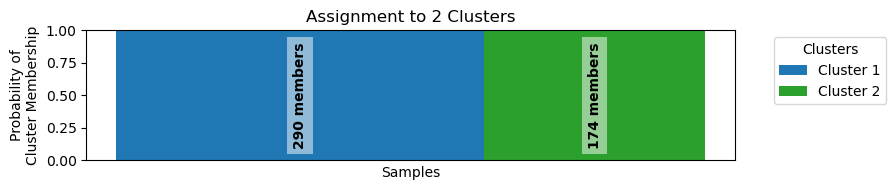

Processing representative profile for Cluster 1...


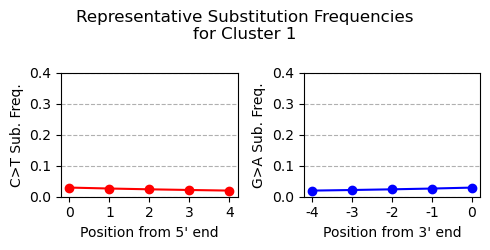

Processing representative profile for Cluster 2...


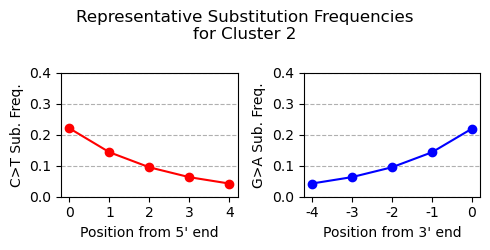

Running clustering for k_iter = 3...


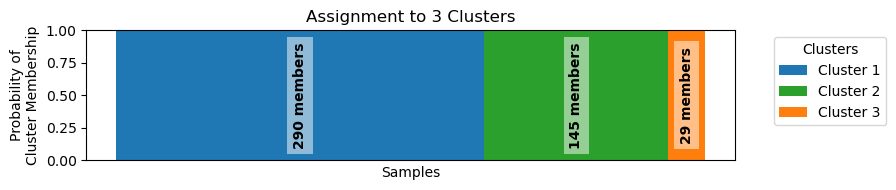

Processing representative profile for Cluster 1...


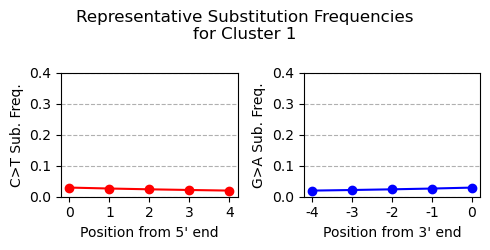

Processing representative profile for Cluster 2...


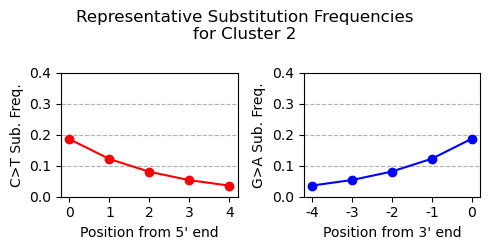

Processing representative profile for Cluster 3...


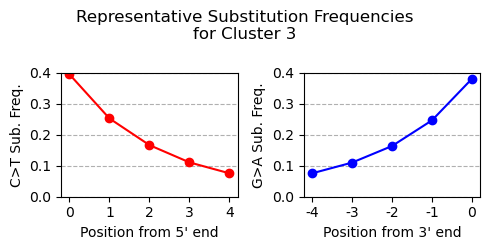

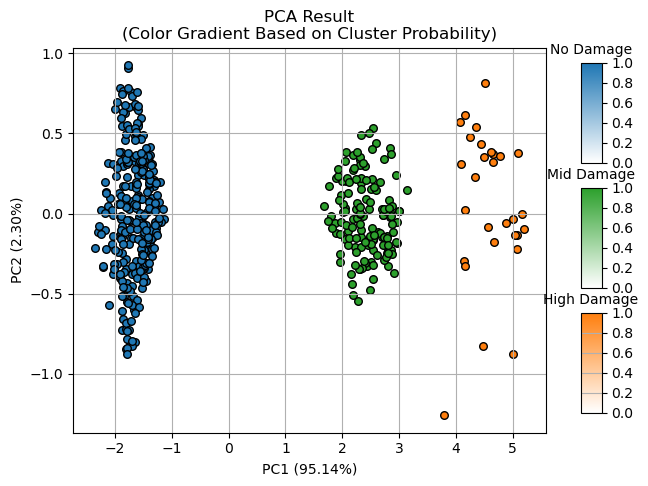

In [17]:
# Iterate over k_iter for GMM, hierarchical clustering, and soft k-means in one block
for k_iter in range(2, 4):
    print(f'Running clustering for k_iter = {k_iter}...')
    
    # Perform GMM clustering
    gmm_model, gmm_cluster_assignments, gmm_probabilities = perform_gmm(combined_matrix, n_components=k_iter)
    gmm_plot_path = create_plot_directories(plot_path, "GMM", k_iter)
    #plot_cluster_assignments(gmm_probabilities, sample_names, gmm_plot_path, "GMM", n_components=k_iter)
    
    plot_gmm_cluster_probabilities(gmm_probabilities, sample_names, gmm_plot_path, n_components=k_iter)


    plot_weighted_profiles(gmm_probabilities, sample_names, damage_paths, gmm_plot_path, True, "GMM", k_iter)
    
    # Make PCA Plot with gradient
    if k_iter == 3:
        plot_pca_gradient(transformed_data, sample_names, gmm_probabilities, pca_plot_path, explained_variance=explained_variance)
    
